In [2]:
device = 'cuda:0'

In [3]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import preprocessing, metrics
from ipywidgets import widgets, interactive
import gc
import joblib
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta 
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
from itertools import cycle
import datetime as dt
from torch.autograd import Variable
import random 
import os
from matplotlib.pyplot import figure
from fastprogress import master_bar, progress_bar
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time 
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import torch 

%matplotlib inline

#from gensim.models import Word2Vec
#import gensim.downloader as api

pd.set_option('display.max_columns', 50)  
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [4]:
INPUT_DIR_PATH = 'C:/Users/Ho Hau/Downloads/M5/data/raw/'

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df



    

In [6]:
def read_data():
    # Use the original INPUT_DIR_PATH from the first cell instead of hardcoding it
    # INPUT_DIR_PATH = '/content/'  # Điều chỉnh đường dẫn nếu cần
    sell_prices_df = pd.read_csv(INPUT_DIR_PATH + 'sell_prices.csv')
    sell_prices_df = reduce_mem_usage(sell_prices_df)
    print('Sell prices has {} rows and {} columns'.format(sell_prices_df.shape[0], sell_prices_df.shape[1]))

    calendar_df = pd.read_csv(INPUT_DIR_PATH + 'calendar.csv')
    calendar_df = reduce_mem_usage(calendar_df)
    print('Calendar has {} rows and {} columns'.format(calendar_df.shape[0], calendar_df.shape[1]))

    sales_train_validation_df = pd.read_csv(INPUT_DIR_PATH + 'sales_train_validation.csv')
    sales_train_validation_df = reduce_mem_usage(sales_train_validation_df)
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation_df.shape[0], sales_train_validation_df.shape[1]))

    submission_df = pd.read_csv(INPUT_DIR_PATH + 'sample_submission.csv')
    submission_df = reduce_mem_usage(submission_df)
    print('Submission has {} rows and {} columns'.format(submission_df.shape[0], submission_df.shape[1]))

    return sell_prices_df, calendar_df, sales_train_validation_df, submission_df

In [7]:
sell_prices_df, calendar_df, sales_train_validation_df, submission_df = read_data()

Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 95.00 Mb (78.7% reduction)
Sales train validation has 30490 rows and 1919 columns
Mem. usage decreased to  2.09 Mb (84.5% reduction)
Submission has 60980 rows and 29 columns


In [8]:
#Create date index
date_index = calendar_df['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [9]:
# Create a data frame for items sales per day with item ids (with Store Id) as columns names  and dates as the index 
sales_train_validation_df['item_store_id'] = sales_train_validation_df.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
DF_Sales = sales_train_validation_df.loc[:,'d_1':'d_1913'].T
DF_Sales.columns = sales_train_validation_df['item_store_id'].values

#Set Dates as index 
DF_Sales = pd.DataFrame(DF_Sales).set_index([dates_list])
DF_Sales.index = pd.to_datetime(DF_Sales.index)
DF_Sales.head()

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,HOBBIES_1_011_CA_1,HOBBIES_1_012_CA_1,HOBBIES_1_013_CA_1,HOBBIES_1_014_CA_1,HOBBIES_1_015_CA_1,HOBBIES_1_016_CA_1,HOBBIES_1_017_CA_1,HOBBIES_1_018_CA_1,HOBBIES_1_019_CA_1,HOBBIES_1_020_CA_1,HOBBIES_1_021_CA_1,HOBBIES_1_022_CA_1,HOBBIES_1_023_CA_1,HOBBIES_1_024_CA_1,HOBBIES_1_025_CA_1,...,FOODS_3_803_WI_3,FOODS_3_804_WI_3,FOODS_3_805_WI_3,FOODS_3_806_WI_3,FOODS_3_807_WI_3,FOODS_3_808_WI_3,FOODS_3_809_WI_3,FOODS_3_810_WI_3,FOODS_3_811_WI_3,FOODS_3_812_WI_3,FOODS_3_813_WI_3,FOODS_3_814_WI_3,FOODS_3_815_WI_3,FOODS_3_816_WI_3,FOODS_3_817_WI_3,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
2011-01-29,0,0,0,0,0,0,0,12,2,0,0,0,0,0,4,5,0,0,0,0,0,2,2,0,0,...,0,14,0,0,7,4,0,0,0,0,0,0,0,0,0,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,0,2,0,0,0,1,0,0,0,0,0,1,1,0,0,...,0,7,0,0,6,13,0,0,0,4,0,0,0,0,1,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,...,0,6,0,0,9,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,...,0,9,0,0,1,1,0,0,0,1,0,0,0,0,1,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,2,0,0,...,0,0,0,0,6,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,0,0,2,0,0


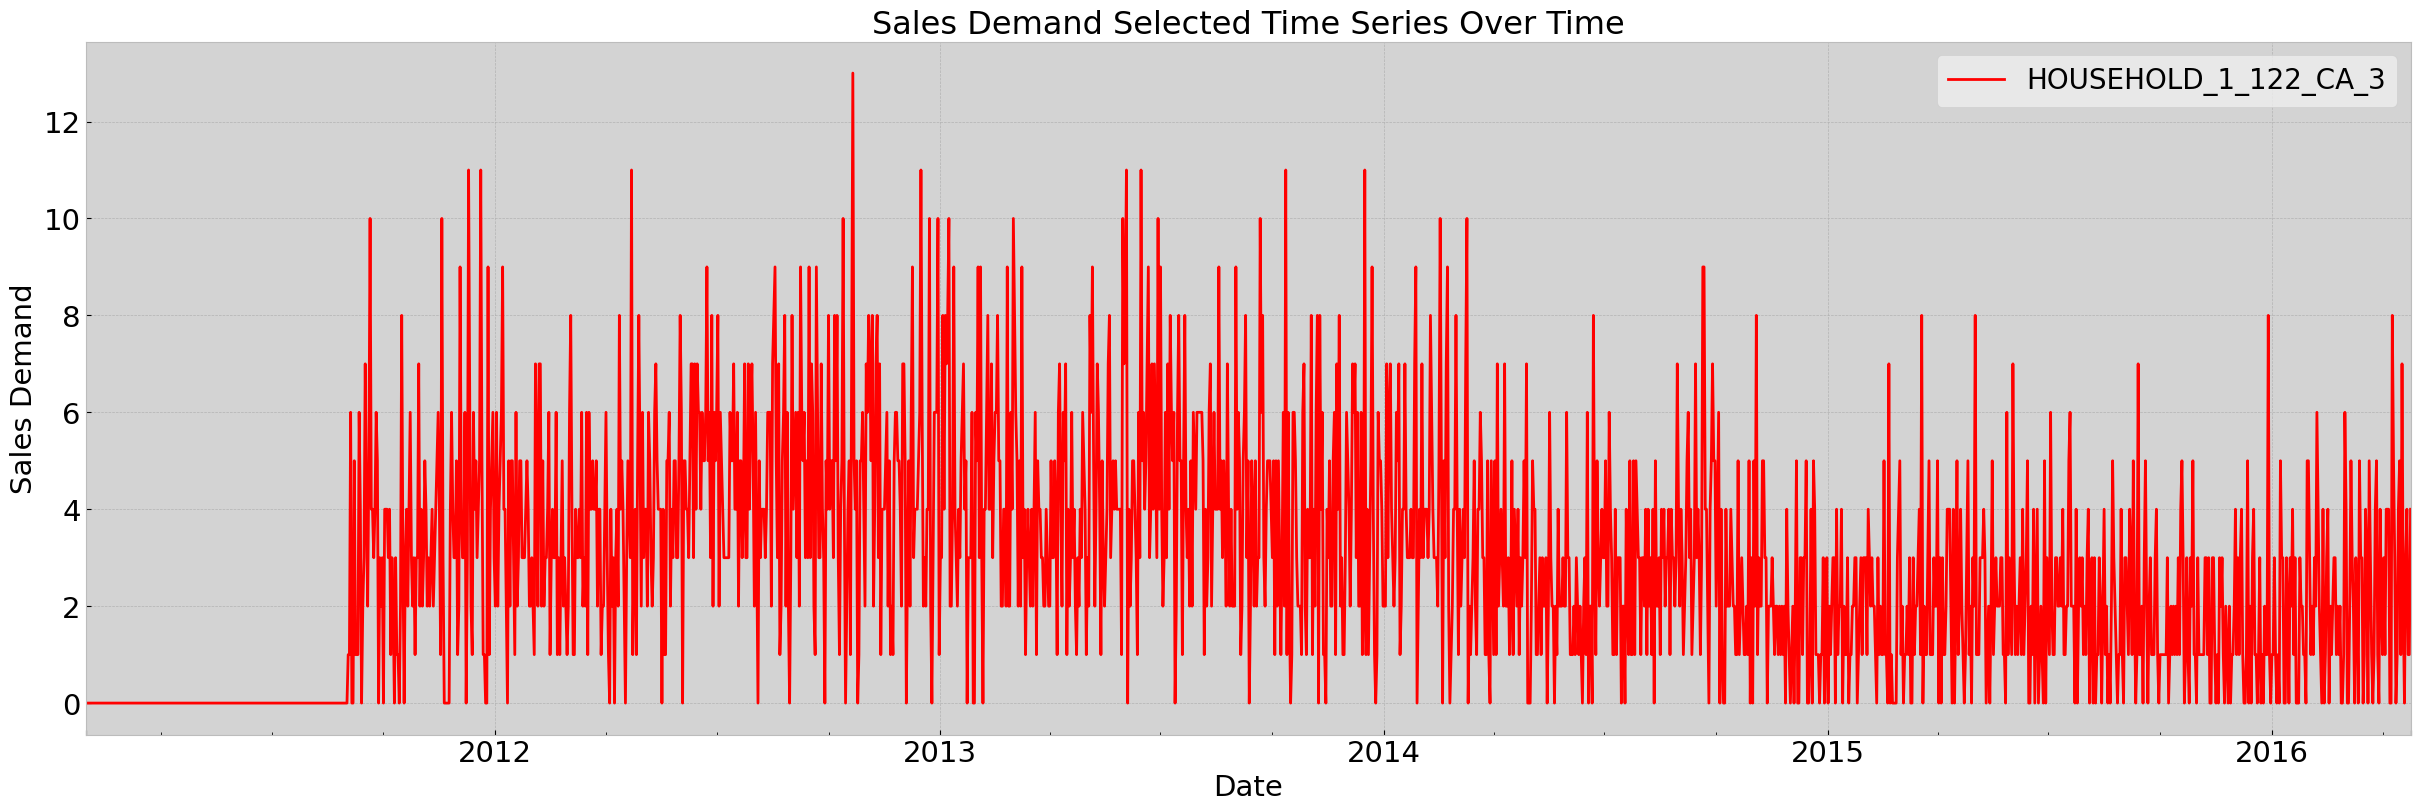

In [10]:
#Select arbitrary index and plot the time series
index = 6780
y = pd.DataFrame(DF_Sales.iloc[:,index])
y = pd.DataFrame(y).set_index([dates_list])
TS_selected = y 
y.index = pd.to_datetime(y.index)
ax = y.plot(figsize=(30, 9),color='red')
ax.set_facecolor('lightgrey')
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.legend(fontsize=20)
plt.title(label = 'Sales Demand Selected Time Series Over Time',fontsize = 23)
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [11]:
SEED = 1345
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(SEED)

## Normlize Data <a id="4"></a>
Normalization is a technique often applied as part of data preparation for machine learning.
The goal of normalization is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values.
For machine learning, every dataset does not require normalization.
It is required only when features have different rangesor scales.



Normalizes our data using the min/max scaler with minimum and maximum values of -1 and 1, respectively

In [12]:
data = np.array(y)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(data.reshape(-1, 1))

In [13]:
y

,HOUSEHOLD_1_122_CA_3
2011-01-29,0
2011-01-30,0
2011-01-31,0
2011-02-01,0
2011-02-02,0
...,...
2016-04-20,3
2016-04-21,4
2016-04-22,1
2016-04-23,1


In [14]:
train_data_normalized

array([[-1.        ],
       [-1.        ],
       [-1.        ],
       ...,
       [-0.84615385],
       [-0.84615385],
       [-0.38461538]])

## Plot The distribution 
Plot the distribution before and after the Normalization. 
As you can see, we kept the distribution of the data, but we change its scales.

<Axes: title={'center': ' After Normalization'}, ylabel='Frequency'>

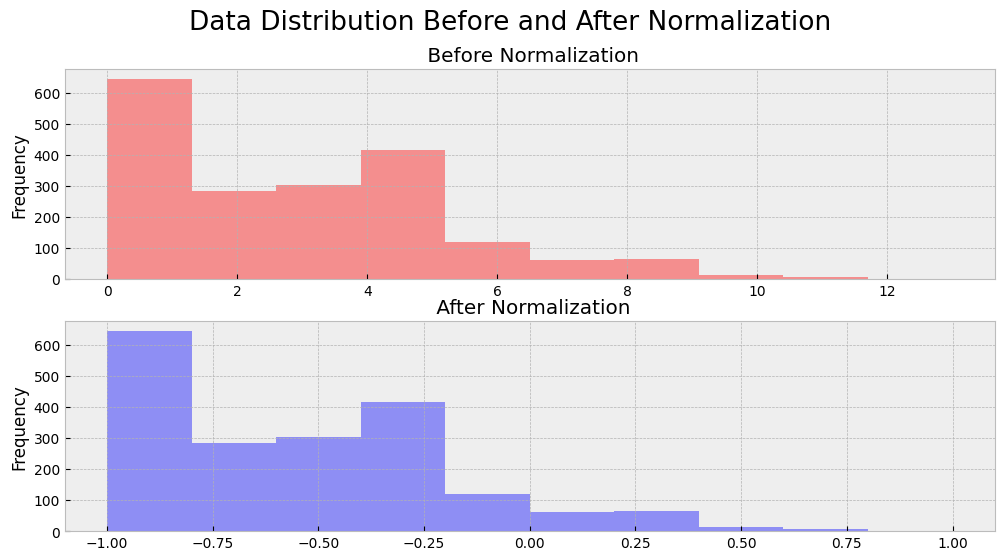

In [15]:
fig, axs = plt.subplots(2)
 
fig.suptitle('Data Distribution Before and After Normalization ',fontsize = 19)
pd.DataFrame(data).plot(kind='hist',ax = axs[0] , alpha=.4 , figsize=[12,6], legend = False,title = ' Before Normalization',color ='red') 
pd.DataFrame(train_data_normalized).plot(kind='hist', ax = axs[1] ,figsize=[12,6], alpha=.4 , legend = False,title = ' After Normalization'\
                                         ,color = 'blue')

Create Sequances

In [16]:
###  This function creates a sliding window or sequences of 28 days and one day label ####
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [17]:
#train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
seq_length = 28
x, y = sliding_windows(train_data_normalized, seq_length)
print(x.shape)
print(y.shape)

(1884, 28, 1)
(1884, 1)


In [18]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [19]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        out = self.dropout(out)
       
        return out

In [20]:
# create a nn class (just-for-fun choice :-) 
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [21]:
#####  Parameters  ######################
num_epochs = 500
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 1
num_classes = 1

#####Init the Model #######################
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

##### Set Criterion Optimzer and scheduler ####################
criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    
    optimizer.step()
    
    #Evaluate on test     
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

Epoch: 0, loss: 0.38260 valid loss:  0.40843 
Epoch: 50, loss: 0.16627 valid loss:  0.09305 
Epoch: 100, loss: 0.15530 valid loss:  0.10364 
Epoch: 150, loss: 0.16249 valid loss:  0.09941 
Epoch: 200, loss: 0.15092 valid loss:  0.08679 
Epoch: 250, loss: 0.15174 valid loss:  0.09415 
Epoch: 300, loss: 0.15332 valid loss:  0.09847 
Epoch: 350, loss: 0.14259 valid loss:  0.08376 
Epoch: 400, loss: 0.15758 valid loss:  0.09696 
Epoch: 450, loss: 0.14808 valid loss:  0.09343 


In [22]:
print(torch.__version__)  
print(torch.cuda.is_available())  

2.6.0+cu118
True


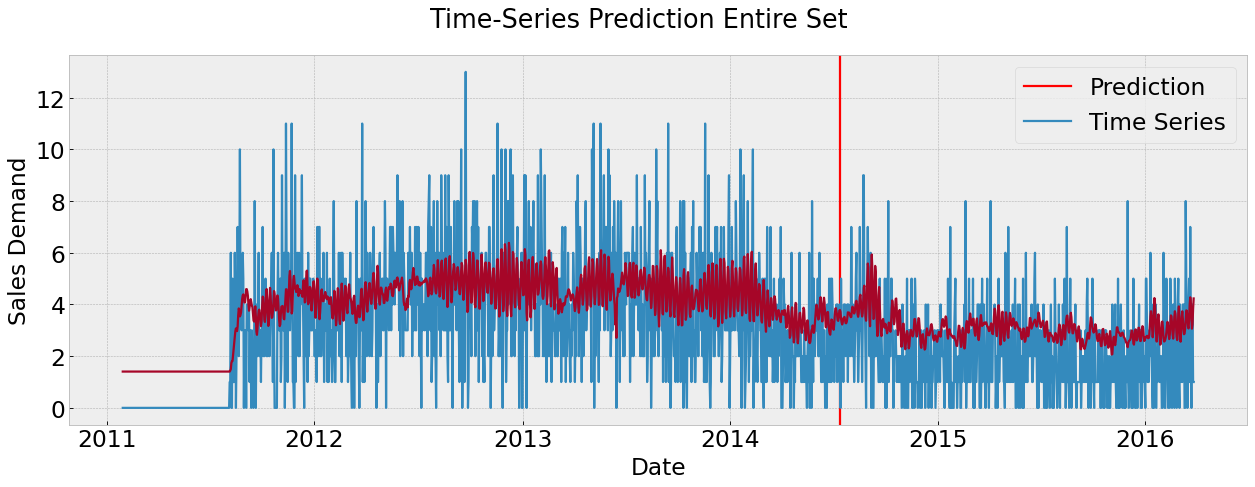

In [23]:
######Prediction###############


lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

## Inverse Normalize 
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot 
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

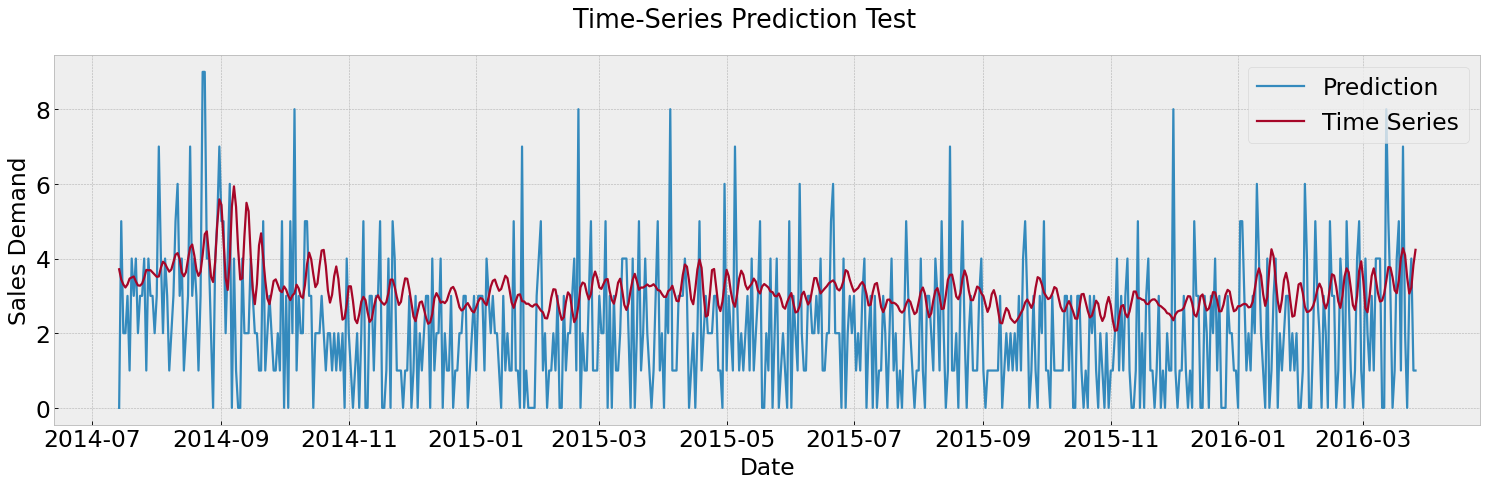

In [24]:
#######Plot the test set ##########################
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Lấy giá trị thực tế và dự đoán trên tập kiểm tra
test_actual = df_labels.iloc[-testX.size()[0]:][0].values
test_predicted = df_predict.iloc[-testX.size()[0]:][0].values

# Tính toán các chỉ số đánh giá
mae = mean_absolute_error(test_actual, test_predicted)
mse = mean_squared_error(test_actual, test_predicted)
rmse = np.sqrt(mse)

# In kết quả
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 1.6487
Mean Squared Error (MSE): 3.8434
Root Mean Squared Error (RMSE): 1.9605


In [26]:
# Đảm bảo các thư viện cần thiết đã được import
import torch
import numpy as np
import pandas as pd
from datetime import timedelta

# Định nghĩa hàm dự báo
def forecast_future_sales(model, input_sequence, future_steps, scaler, start_date, product_id, device='cpu'):
    """
    Dự báo doanh số trong tương lai.

    Args:
        model: Mô hình LSTM đã huấn luyện.
        input_sequence: Chuỗi dữ liệu đầu vào (numpy array) có kích thước (seq_length, 1).
        future_steps: Số bước dự báo trong tương lai.
        scaler: Bộ scaler đã sử dụng để chuẩn hóa dữ liệu.
        start_date: Ngày cuối cùng trong dữ liệu hiện tại (datetime object).
        product_id: Mã sản phẩm cần dự báo.
        device: Thiết bị để chạy mô hình ('cpu' hoặc 'cuda').

    Returns:
        predictions_df: DataFrame chứa ngày, mã sản phẩm và giá trị dự báo.
    """
    model.eval()
    input_sequence = torch.Tensor(input_sequence).unsqueeze(0).to(device)  # Thêm batch dimension
    predictions = []

    for _ in range(future_steps):
        with torch.no_grad():
            prediction = model(input_sequence)
            predictions.append(prediction.item())

            # Cập nhật chuỗi đầu vào với giá trị dự báo
            prediction = prediction.unsqueeze(2)  # Thêm feature dimension
            input_sequence = torch.cat((input_sequence[:, 1:, :], prediction), dim=1)

    # Inverse transform để đưa dữ liệu về giá trị gốc
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

    # Tạo DataFrame kết quả
    dates = [start_date + timedelta(days=i) for i in range(1, future_steps + 1)]
    predictions_df = pd.DataFrame({
        'Date': dates,
        'Product_ID': product_id,
        'Predicted_Sales': predictions
    })

    return predictions_df

# Khởi chạy dự báo
future_steps = 30  # Dự báo 30 ngày tiếp theo
last_sequence = train_data_normalized[-28:]  # Lấy chuỗi dữ liệu cuối cùng làm đầu vào
start_date = pd.to_datetime("2025-04-02")  # Ngày cuối cùng trong dữ liệu hiện tại
product_id = "SP001"  # Mã sản phẩm cần dự báo

# Gọi hàm dự báo
future_predictions_df = forecast_future_sales(lstm, last_sequence, future_steps, scaler, start_date, product_id, device)

# Hiển thị kết quả dự báo
print("Dự báo doanh số trong tương lai:")
print(future_predictions_df)

Dự báo doanh số trong tương lai:
         Date Product_ID  Predicted_Sales
0  2025-04-03      SP001         3.777027
1  2025-04-04      SP001         3.391729
2  2025-04-05      SP001         3.104110
3  2025-04-06      SP001         3.150287
4  2025-04-07      SP001         3.610346
5  2025-04-08      SP001         4.059896
6  2025-04-09      SP001         4.106944
7  2025-04-10      SP001         3.767210
8  2025-04-11      SP001         3.330449
9  2025-04-12      SP001         3.274171
10 2025-04-13      SP001         3.749095
11 2025-04-14      SP001         4.367288
12 2025-04-15      SP001         4.481776
13 2025-04-16      SP001         4.131058
14 2025-04-17      SP001         3.845849
15 2025-04-18      SP001         3.799864
16 2025-04-19      SP001         3.962302
17 2025-04-20      SP001         4.118619
18 2025-04-21      SP001         4.277728
19 2025-04-22      SP001         4.446625
20 2025-04-23      SP001         4.439059
21 2025-04-24      SP001         4.282014
2

In [27]:
# Lưu trạng thái của mô hình
torch.save(lstm.state_dict(), 'lstm_model.pth')
print("Mô hình đã được lưu thành công!")

Mô hình đã được lưu thành công!


In [28]:
import os
print("Thư mục hiện tại:", os.getcwd())

Thư mục hiện tại: c:\Users\Ho Hau\Downloads\M5\backend


In [29]:
import os

def print_directory_tree(startpath, indent=""):
    for item in os.listdir(startpath):
        item_path = os.path.join(startpath, item)
        if os.path.isdir(item_path):
            print(f"{indent}├── {item}/")
            print_directory_tree(item_path, indent + "│   ")
        else:
            print(f"{indent}├── {item}")

# Thư mục hiện tại
project_path = os.getcwd()
print(f"Dự án: {project_path}")
print_directory_tree(project_path)

Dự án: c:\Users\Ho Hau\Downloads\M5\backend
├── app.py
├── database/
│   ├── db_connecttion.py
│   ├── db_insert.py
│   ├── db_setup.py
│   ├── m5_forecasting.db
│   ├── __pycache__/
│   │   ├── db_connecttion.cpython-312.pyc
├── datapreprocessing.ipynb
├── lstm_model.pth
├── models/
│   ├── evaluate.py
│   ├── lstm_model.py
│   ├── predict.py
│   ├── train.py
│   ├── utils.py
│   ├── __pycache__/
│   │   ├── lstm_model.cpython-312.pyc
│   │   ├── predict.cpython-312.pyc
├── routes/
│   ├── forecast.py
│   ├── __pycache__/
│   │   ├── forecast.cpython-312.pyc
├── services/
├── test.py


In [32]:
import pandas as pd
import os

# Chuyển mảng numpy thành DataFrame
df_normalized = pd.DataFrame(train_data_normalized)

# Đảm bảo thư mục lưu trữ tồn tại
output_dir = "../data/processed/"
os.makedirs(output_dir, exist_ok=True)

# Lưu DataFrame vào CSV
output_file = os.path.join(output_dir, "train_data_normalized.csv")
df_normalized.to_csv(output_file, index=False)

print(f"Dữ liệu đã được lưu tại: {output_file}")


Dữ liệu đã được lưu tại: ../data/processed/train_data_normalized.csv


In [33]:
print(type(train_data_normalized))


<class 'numpy.ndarray'>


In [34]:
print(train_data_normalized.shape)


(1913, 1)
